# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

import time
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import xgboost as xgb

# Metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

#from sklearn import preprocessing
#from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV

# Import prepared dataframes

In [2]:
# Bitcoin
df_btc = pd.read_csv('df_btc.csv')
df_btc.Date = pd.to_datetime(df_btc.Date)

# Twitter
df_tw = pd.read_csv('df_tw_agg.csv')
df_tw.Date = pd.to_datetime(df_tw.Date)

# Construct the analysis dataframe

### Select the Twitter variables to be used

In [3]:
variables = list(df_tw.columns)

### Merge Bitcoin and Twitter dataframes

In [4]:
# Apply selection on the BTC dataframe
df_ana = df_btc[(df_btc.Date >= pd.to_datetime('01-04-2020', format='%d-%m-%Y')) & \
       (df_btc.Date < pd.to_datetime('15-03-2021', format='%d-%m-%Y'))]
#df_ana = df_ana[['Date', 'Close', 'Close_next1', 'Close_diff_next1', 'Close_diff_next1_rel', 'Close_diff_next1_sgn']]
df_ana = df_ana.dropna()

# Merge with TW dataframe
df_ana = pd.merge(left=df_ana, right=df_tw[variables], how='inner', left_on='Date', right_on='Date')
df_ana.dropna(inplace=True)

### Study correlations among features

<AxesSubplot:>

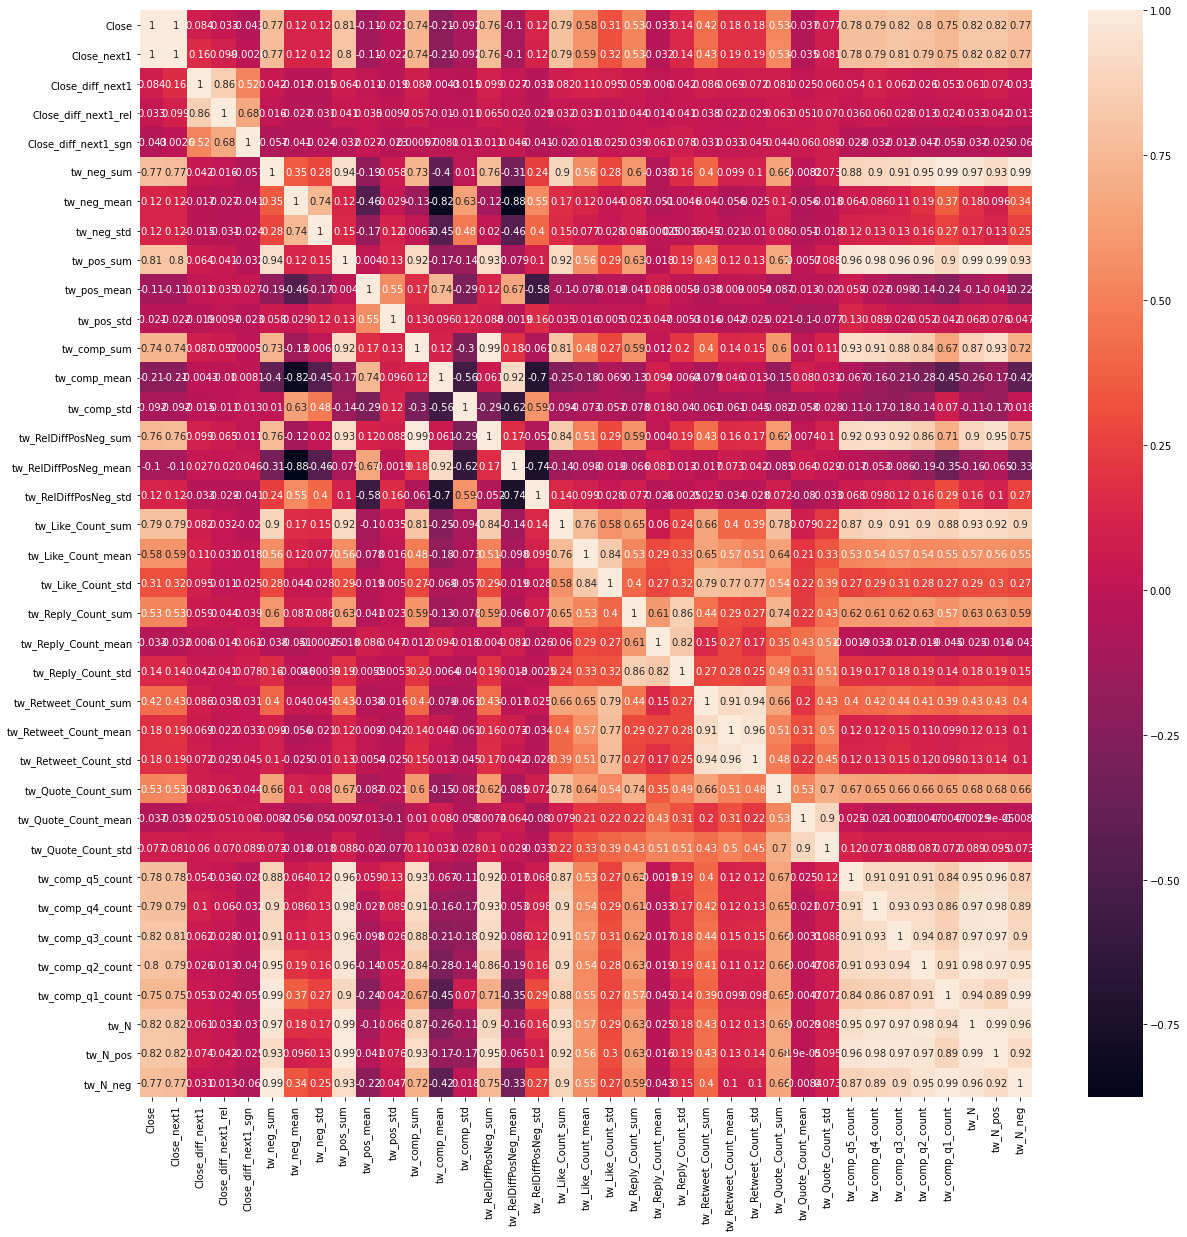

In [11]:
corr = df_ana.corr()
plt.figure(figsize = (20,20))
sb.heatmap(corr,annot=True)

# Modelling

## Target: next day's Bitcoin Close price

### Prepare training and testing datasets

In [5]:
# Define target and input variables
target = 'Close_next1'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_test.sort_values(by=['Date'], inplace=True)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [6]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [7]:
y_pred=model.predict(X_test_tmp)
X_test['Pred_next1'] = list(y_pred)
X_test['Pred_diff_next1'] = (X_test.Pred_next1 - X_test.Close).to_list()
X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1)

<ipython-input-7-e9ddb46e0ea7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_next1'] = list(y_pred)
<ipython-input-7-e9ddb46e0ea7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = (X_test.Pred_next1 - X_test.Close).to_list()
<ipython-input-7-e9ddb46e0ea7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

### Performance evaluation

In [8]:
print('==================================================================================')
print('Performance on the target variable: next day\'s BTC Close price' )
test = X_test['Close_next1']
pred = X_test['Pred_next1']
print('+++ Next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the absolute diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1']
pred = X_test['Pred_diff_next1']
print('+++ Diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the target variable: next day's BTC Close price
+++ Next day BTC price
Explained variance:    0.9761966295436486
R2:                    0.9761452213274823
MAE:                   1054.3936712779853
MSE:                   3445274.6029079263

Performance on the absolute diff between today's and next day's BTC Close price
+++ Diff to next day BTC price
Explained variance:    -3.299670238689398
R2:                    -3.308956250411131
MAE:                   1054.3936712779853
MSE:                   3445274.6029079263

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    -2.9950939209799468
R2:                    -980.1640172844008
MAE:                   1.00352456495915
MSE:                   1.0111788605387086

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.417910447761194


### Plot predictions

<ipython-input-9-c9312ce135ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.sort_values(by=['Date'], inplace=True)


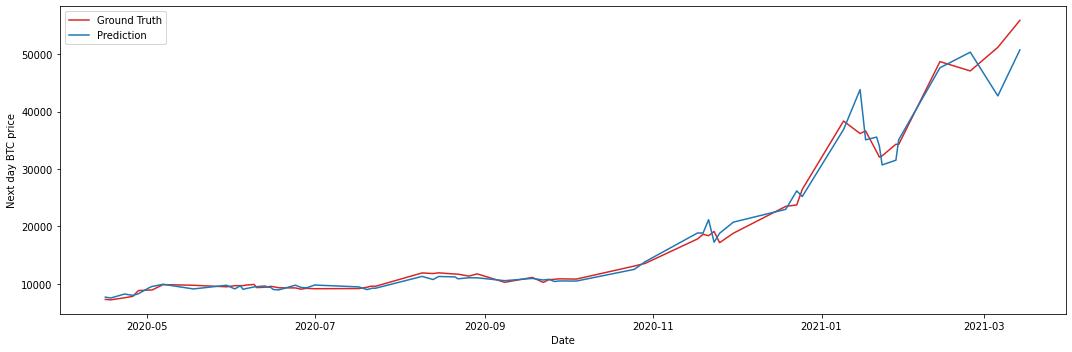

In [9]:
# Next day's BTC price

X_test.sort_values(by=['Date'], inplace=True)
x = X_test.Date
y_test = X_test['Close_next1']
y_pred = X_test['Pred_next1']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Next day BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

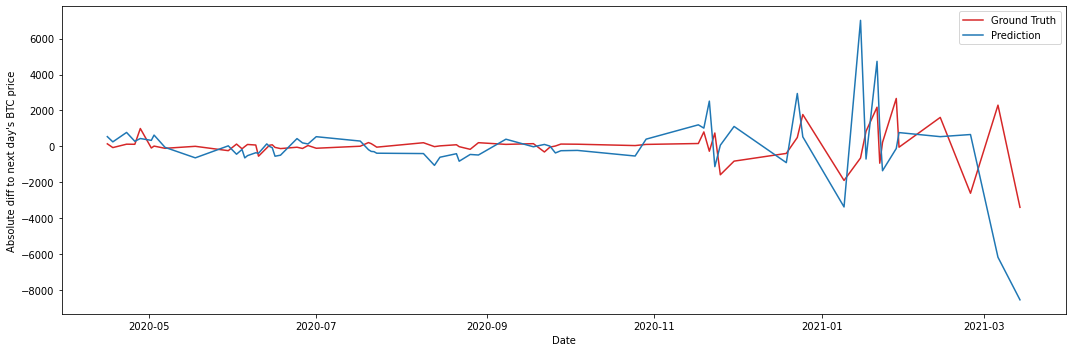

In [10]:
# Absolute diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1']
y_pred = X_test['Pred_diff_next1']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Absolute diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

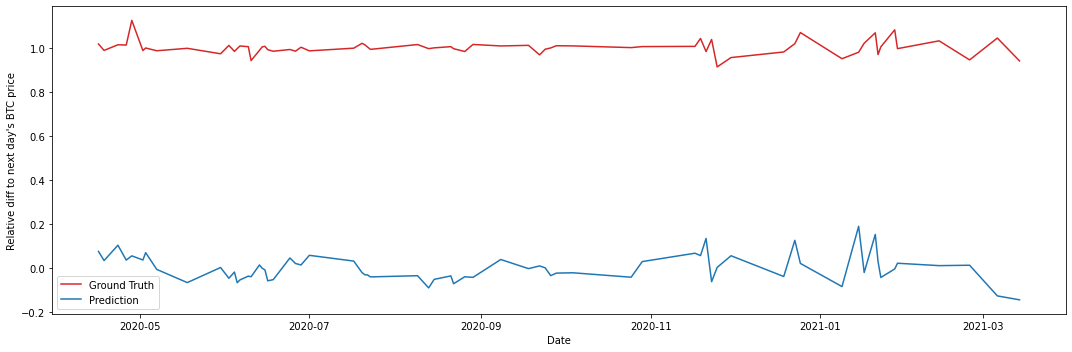

In [11]:
# Relative diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1_rel']
y_pred = X_test['Pred_diff_next1_rel']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Relative diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

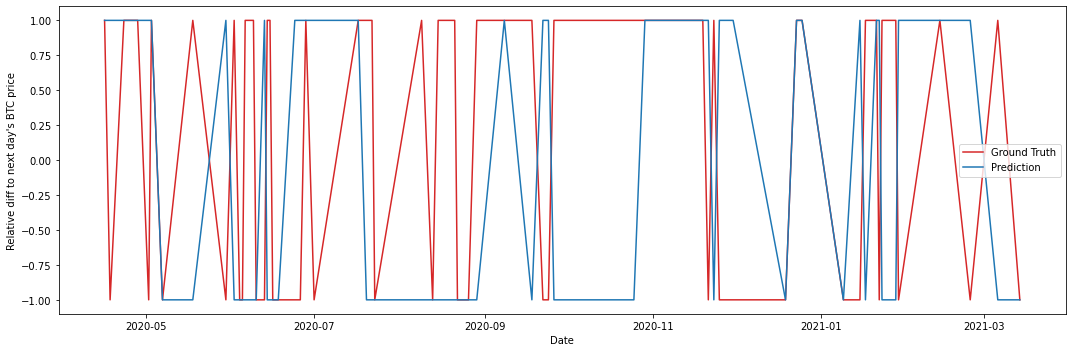

In [12]:
# Signed diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1_sgn']
y_pred = X_test['Pred_diff_next1_sgn']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Relative diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Feature importance

Importance type: weight
{'tw_neg_sum': 1014, 'tw_neg_mean': 668, 'tw_neg_std': 450, 'tw_pos_std': 379, 'tw_pos_mean': 374, 'tw_pos_sum': 341, 'tw_Retweet_Count_sum_last10_mean': 314, 'tw_Like_Count_mean': 276, 'tw_Reply_Count_mean': 256, 'tw_topic2_freq': 251, 'tw_comp_sum': 240, 'tw_neg_sum_last10_mean': 235, 'tw_Like_Count_sum': 232, 'tw_comp_std': 232, 'tw_comp_sum_last10_std': 231, 'tw_RelDiffPosNeg_sum_last10_mean': 224, 'tw_topic1_freq': 211, 'tw_topic3_freq': 210, 'tw_Quote_Count_sum_last10_std': 209, 'tw_Retweet_Count_mean': 205, 'tw_Reply_Count_sum_last10_std': 205, 'tw_pos_sum_last10_mean': 203, 'tw_RelDiffPosNeg_std': 202, 'tw_neg_sum_last10_std': 197, 'tw_pos_sum_last10_std': 196, 'tw_Reply_Count_sum_last5_std': 193, 'tw_Quote_Count_sum_last10_mean': 192, 'tw_comp_mean': 190, 'tw_comp_sum_last10_mean': 187, 'tw_RelDiffPosNeg_sum': 183, 'tw_Like_Count_std': 181, 'tw_neg_sum_last5_std': 180, 'tw_comp_sum_last5_std': 169, 'tw_Quote_Count_sum_last5_std': 162, 'tw_N_neg_last10_s

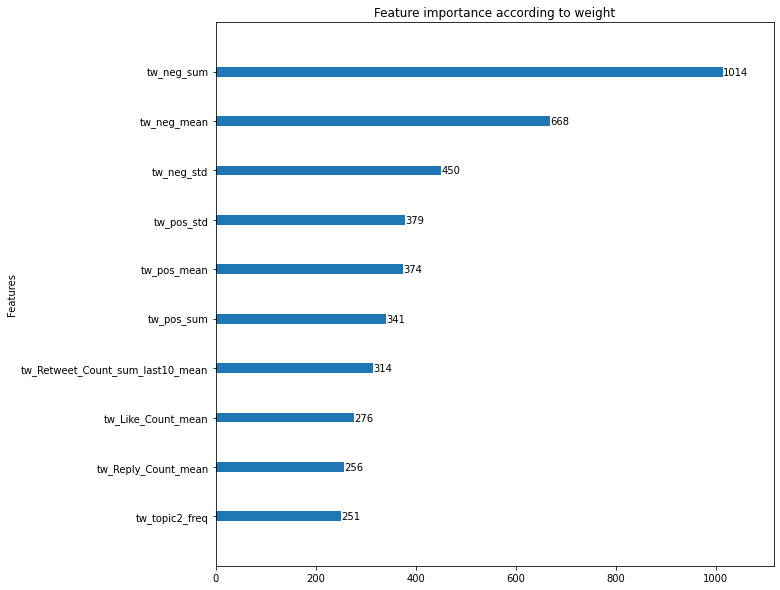

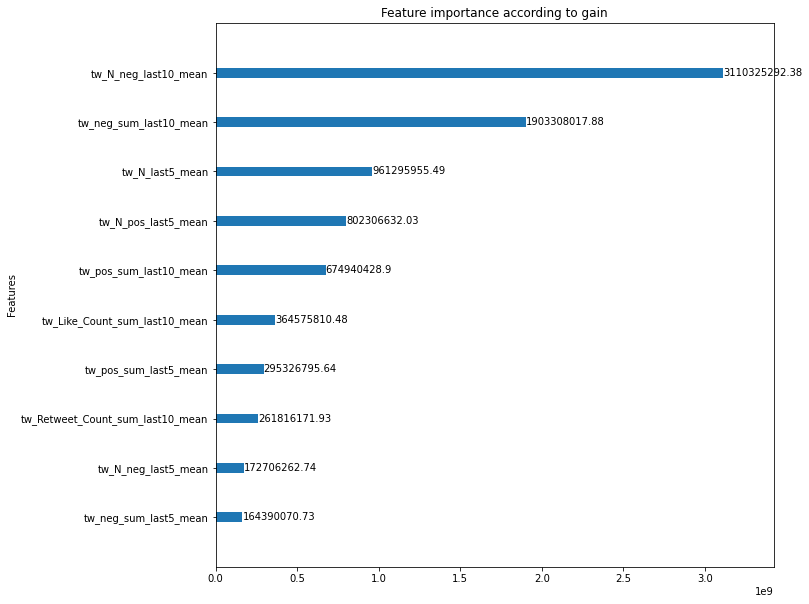

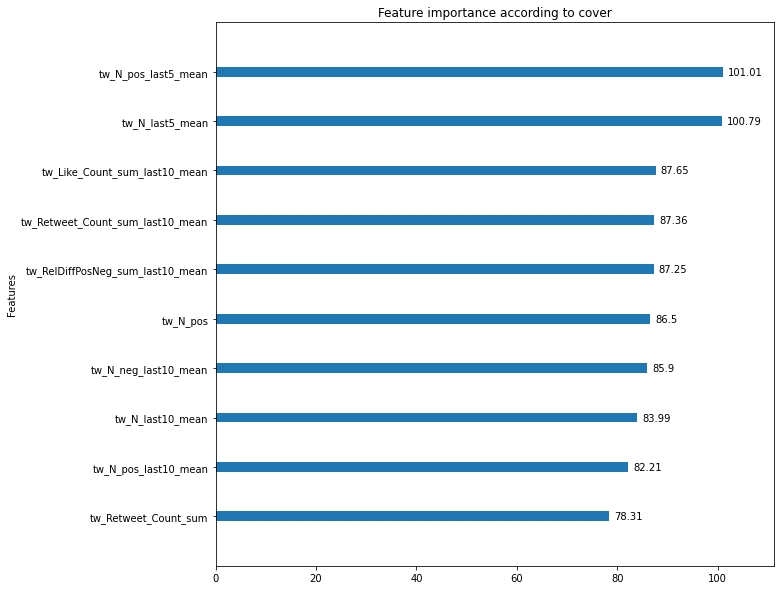

In [13]:
import operator

for importance_type in ['weight', 'gain', 'cover']:

    # Get the importance dictionary (by gain) from the booster
    importance = model.get_booster().get_score(importance_type=importance_type)

    # make your changes
    for key in importance.keys():
        importance[key] = round(importance[key],2)
        
    print('==============')
    print(f'Importance type: {importance_type}')
    print(dict(sorted(importance.items(),
                            key=operator.itemgetter(1),
                            reverse=True)))

    # provide the importance dictionary to the plotting function
    #ax = plot_importance(importance, max_num_features=3, importance_type='gain', show_values=True)

    # Plot variable importance
    ax = xgb.plot_importance(importance, max_num_features=10, grid=False, xlabel=None,\
                             title='Feature importance according to '+importance_type)
    fig = ax.figure
    fig.set_size_inches(10, 10)

## Target: Absolute difference to the next day's BTC Close price

### Prepare training and testing datasets

In [14]:
# Define target and input variables
target = 'Close_diff_next1'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [15]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [16]:
y_pred=model.predict(X_test_tmp)

X_test['Pred_diff_next1'] = list(y_pred)
X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1)

<ipython-input-16-b6d71e7a9ad9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = list(y_pred)
<ipython-input-16-b6d71e7a9ad9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
<ipython-input-16-b6d71e7a9ad9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

### Performance evaluation

In [17]:
print('==================================================================================')
print('Performance on the absolute diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1']
pred = X_test['Pred_diff_next1']
print('+++ Diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the absolute diff between today's and next day's BTC Close price
+++ Diff to next day BTC price
Explained variance:    -0.1485947138476691
R2:                    -0.16994901877180046
MAE:                   541.365710856809
MSE:                   935445.9425497628

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    -0.20160352932034198
R2:                    -963.6949629408953
MAE:                   0.9964776156963714
MSE:                   0.9942060004339248

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.5373134328358209


Importance type: weight
{'tw_neg_sum': 1477, 'tw_neg_mean': 927, 'tw_neg_std': 533, 'tw_pos_mean': 444, 'tw_pos_std': 416, 'tw_pos_sum': 383, 'tw_comp_std': 352, 'tw_RelDiffPosNeg_std': 321, 'tw_neg_sum_last10_mean': 293, 'tw_comp_sum': 276, 'tw_Retweet_Count_sum_last5_std': 272, 'tw_topic1_freq': 262, 'tw_Reply_Count_mean': 244, 'tw_Retweet_Count_sum_last10_std': 240, 'tw_Quote_Count_sum_last10_std': 233, 'tw_Retweet_Count_mean': 225, 'tw_Like_Count_mean': 223, 'tw_Reply_Count_sum': 222, 'tw_comp_mean': 202, 'tw_Reply_Count_sum_last5_mean': 199, 'tw_RelDiffPosNeg_mean': 197, 'tw_Like_Count_std': 192, 'tw_topic2_freq': 190, 'tw_neg_sum_last5_std': 189, 'tw_Quote_Count_sum_last5_std': 178, 'tw_Like_Count_sum_last10_std': 175, 'tw_Quote_Count_mean': 173, 'tw_topic3_freq': 167, 'tw_neg_sum_last10_std': 167, 'tw_Quote_Count_std': 165, 'tw_RelDiffPosNeg_sum': 161, 'tw_pos_sum_last5_std': 161, 'tw_Retweet_Count_std': 160, 'tw_Reply_Count_std': 159, 'tw_RelDiffPosNeg_sum_last5_std': 153, 'tw_

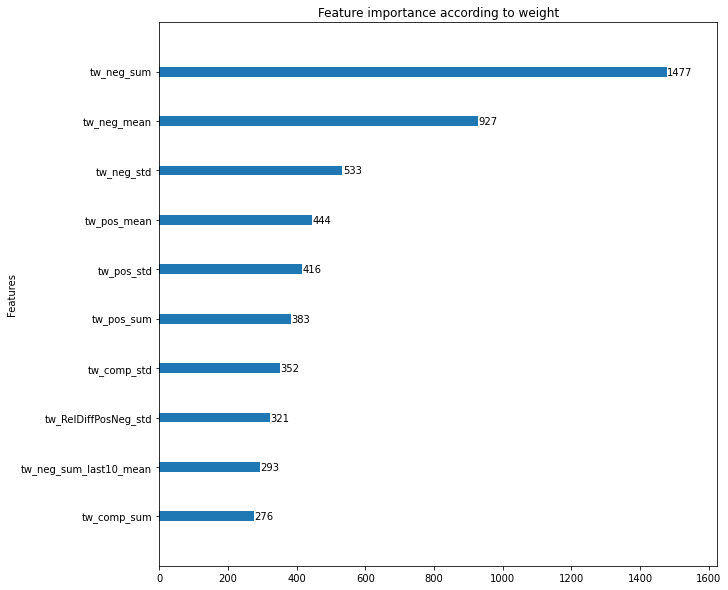

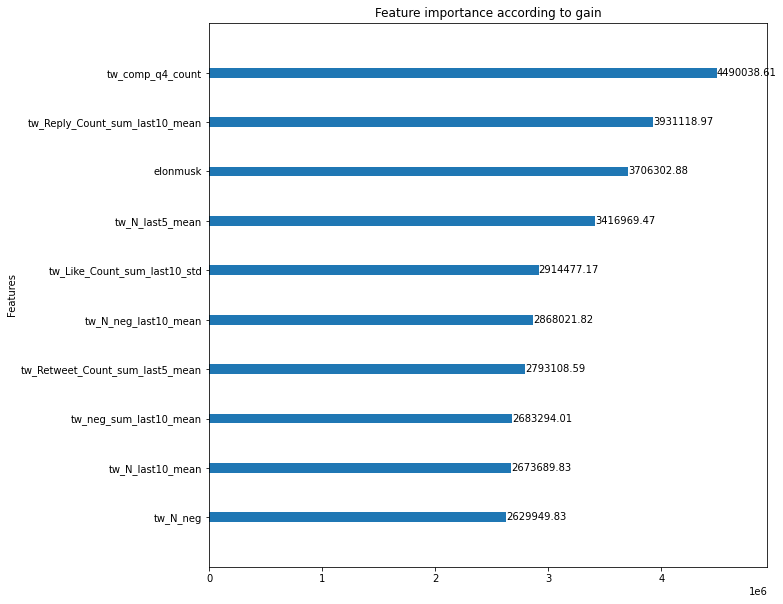

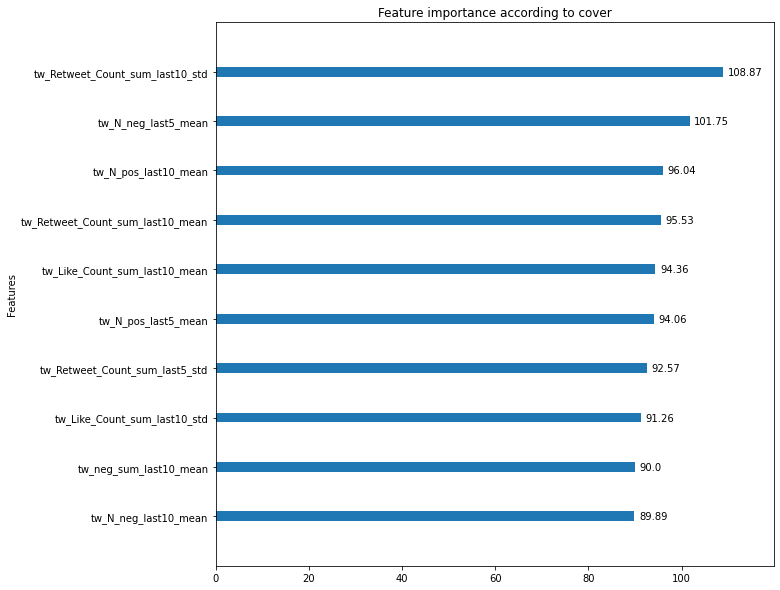

In [18]:
import operator

for importance_type in ['weight', 'gain', 'cover']:

    # Get the importance dictionary (by gain) from the booster
    importance = model.get_booster().get_score(importance_type=importance_type)

    # make your changes
    for key in importance.keys():
        importance[key] = round(importance[key],2)
        
    print('==============')
    print(f'Importance type: {importance_type}')
    print(dict(sorted(importance.items(),
                            key=operator.itemgetter(1),
                            reverse=True)))

    # provide the importance dictionary to the plotting function
    #ax = plot_importance(importance, max_num_features=3, importance_type='gain', show_values=True)

    # Plot variable importance
    ax = xgb.plot_importance(importance, max_num_features=10, grid=False, xlabel=None,\
                             title='Feature importance according to '+importance_type)
    fig = ax.figure
    fig.set_size_inches(10, 10)

## Target: Relative difference to the next day's BTC Close price

### Prepare training and testing datasets

In [19]:
# Define target and input variables
target = 'Close_diff_next1_rel'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [20]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [21]:
y_pred=model.predict(X_test_tmp)

X_test['Pred_diff_next1'] = list(y_pred)
X_test['Pred_diff_next1_rel'] = list(y_pred)
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1_rel)

<ipython-input-21-86142636e4f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = list(y_pred)
<ipython-input-21-86142636e4f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1_rel'] = list(y_pred)
<ipython-input-21-86142636e4f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

### Performance evaluation

In [22]:
print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    2.220446049250313e-16
R2:                    -0.01599615010776767
MAE:                   0.021703514819490833
MSE:                   0.001047076545082776

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.5671641791044776


## Target: Signed difference to the next day's BTC Close price

### Prepare training and testing datasets

In [23]:
# Define target and input variables
target = 'Close_diff_next1_sgn'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_test.sort_values(by=['Date'], inplace=True)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [24]:
imbalance = len(y_train)/sum(y_train)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20,\
                              random_state=42, eval_metric=["auc"],\
                             #scale_pos_weight=imbalance
                             )
#eval_metric=["auc", "error", "error@0.6"]

#xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
xgb_model.fit(X_train_tmp, y_train)

y_pred = xgb_model.predict(X_test_tmp)

/Users/snezana/testenv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Performance evaluation

In [25]:
from sklearn.metrics import classification_report,confusion_matrix

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
print()
print('Accuracy:')
print(accuracy_score(y_test,y_pred))
print()
print('Confusion matrix:')
print(confusion_matrix(y_test,y_pred))
print()
print('Classification report:')
print(classification_report(y_test,y_pred))

Performance on the signed diff between today's and next day's BTC Close price

Accuracy:
0.582089552238806

Confusion matrix:
[[13 16]
 [12 26]]

Classification report:
              precision    recall  f1-score   support

        -1.0       0.52      0.45      0.48        29
         1.0       0.62      0.68      0.65        38

    accuracy                           0.58        67
   macro avg       0.57      0.57      0.57        67
weighted avg       0.58      0.58      0.58        67

